# Data Preprocess

## Download data

### Cardiotocography Dataset

The **Cardiotocography (CTG)** dataset contains fetal heart rate (FHR) and uterine contraction (UC) measurements used for assessing fetal well-being.  
It consists of **2,126 samples**, each described by **21 numerical features** extracted from cardiotocogram signals.

The objective is to classify the fetal state into **two categories**:
- *Nomarl*
- *Non-Normal*

This dataset is publicly available and can be accessed through the following sources:
- **UCI Machine Learning Repository:** [https://archive.ics.uci.edu/dataset/193/cardiotocography](https://archive.ics.uci.edu/dataset/193/cardiotocography)
- **Kaggle:** [https://www.kaggle.com/datasets/akshat0007/fetalhr](https://www.kaggle.com/datasets/akshat0007/fetalhr)


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

INPUT_CSV = Path("Flow_Disentangle_Feature_Importance/CTG.csv")  
OUT_PREFIX = INPUT_CSV.with_name("Cardiotocography")  
REQUIRED_FEATS = [
    "LB", "AC", "FM", "UC",
    "ASTV", "mSTV", "ALTV", "mLTV",
    "DL", "DS", "DP",
    "Width", "Min", "Max",
    "Nmax", "Nzeros",
    "Mode", "Mean", "Median", "Variance", "Tendency",
]

ALIASES = {
    "mstv": ["mstv", "m_stv", "m stv"],
    "mltv": ["mltv", "m_ltv", "m ltv"],
    "nmax": ["nmax", "n_max", "n max"],
    "nzeros": ["nzeros", "n_zeros", "n zeros", "nz", "nzero"],
    "astv": ["astv"],
    "altv": ["altv"],  
}

def norm(s: str) -> str:
    return str(s).strip().lower().replace("_", "").replace(" ", "")

def resolve_col(name: str, cols) -> str:
    target = norm(name)
    col_map = {norm(c): c for c in cols}

    if target in col_map:  
        return col_map[target]
    if target in ALIASES:  
        for a in ALIASES[target]:
            aa = norm(a)
            if aa in col_map:
                return col_map[aa]
    raise KeyError(f"Cannot find required column: {name}. Available columns (first few): {list(cols)[:10]} ...")

def main():
    # Read input CSV
    df = pd.read_csv(
        INPUT_CSV,
        na_values=["", "NA", "N/A", "null", "Null", "NULL", "NaN"]
    ).replace(r"^\s*$", pd.NA, regex=True)

    feat_cols = [resolve_col(name, df.columns) for name in REQUIRED_FEATS]
    nsp_col = resolve_col("NSP", df.columns)

    df = df[feat_cols + [nsp_col]].copy()
    nsp_num = pd.to_numeric(df[nsp_col], errors="coerce")
    if nsp_num.notna().any():
        df[nsp_col] = (nsp_num == 3).astype("Int64")
    else:
        nsp_str = df[nsp_col].astype(str).str.strip().str.upper()
        df[nsp_col] = nsp_str.map({"P": 1, "N": 0, "S": 0}).astype("Int64")

    before = len(df)
    df = df.dropna(axis=0).reset_index(drop=True)
    after = len(df)
    print(f"Removed {before-after} rows with missing values; kept {after} rows.")

    X = df[feat_cols].copy()
    y = df[nsp_col].astype(int).copy()

    mu = X.mean(axis=0)
    sd = X.std(axis=0, ddof=0).replace(0, 1.0)  
    X_std = (X - mu) / sd

    merged_out = OUT_PREFIX.with_name("CTG_21feats_binary_Cardiotocography.csv")
    merged_df = X_std.copy()
    merged_df[nsp_col] = y.values
    merged_df.to_csv(merged_out, index=False)

    X_csv = OUT_PREFIX.with_name("X_Cardiotocography.csv")
    y_csv = OUT_PREFIX.with_name("y_Cardiotocography.csv")
    X_npy = OUT_PREFIX.with_name("X_Cardiotocography.npy")
    y_npy = OUT_PREFIX.with_name("y_Cardiotocography.npy")

    X_std.to_csv(X_csv, index=False)
    y.to_csv(y_csv, index=False, header=[nsp_col])
    np.save(X_npy, X_std.to_numpy())
    np.save(y_npy, y.to_numpy())

    print("Export completed:")
    print(" - Combined CSV: ", merged_out.resolve())
    print(" - X CSV:        ", X_csv.resolve())
    print(" - y CSV:        ", y_csv.resolve())
    print(" - X NPY:        ", X_npy.resolve())
    print(" - y NPY:        ", y_npy.resolve())
    print(f"Samples: {len(df)}, X shape: {X_std.shape}, y shape: {y.shape}")

if __name__ == "__main__":
    main()


Removed 3 rows with missing values; kept 2126 rows.
Export completed:
 - Combined CSV:  F:\Code\2025\Module_Flow_Disentangle_Feature_Importance\Flow_Disentangle_Feature_Importance\CTG_21feats_binary_Cardiotocography.csv
 - X CSV:         F:\Code\2025\Module_Flow_Disentangle_Feature_Importance\Flow_Disentangle_Feature_Importance\X_Cardiotocography.csv
 - y CSV:         F:\Code\2025\Module_Flow_Disentangle_Feature_Importance\Flow_Disentangle_Feature_Importance\y_Cardiotocography.csv
 - X NPY:         F:\Code\2025\Module_Flow_Disentangle_Feature_Importance\Flow_Disentangle_Feature_Importance\X_Cardiotocography.npy
 - y NPY:         F:\Code\2025\Module_Flow_Disentangle_Feature_Importance\Flow_Disentangle_Feature_Importance\y_Cardiotocography.npy
Samples: 2126, X shape: (2126, 21), y shape: (2126,)


# Load data and train/test the model

In [ ]:
import numpy as np
x_npy_path = "Flow_Disentangle_Feature_Importance/X_Cardiotocography.npy"
y_npy_path = "Flow_Disentangle_Feature_Importance/y_Cardiotocography.npy"

y = np.load(y_npy_path)

X_full = np.load(x_npy_path); y = np.load(y_npy_path)
print(X_full.shape)
print(y.shape)
D = X_full.shape[1]

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
seed = 0
n_jobs = -1
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

fold_acc = []
for k, (tr_idx, te_idx) in enumerate(skf.split(X_full, y), start=1):
    X_tr, X_te = X_full[tr_idx], X_full[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=3,
        random_state=seed,
        n_jobs=n_jobs
    )
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    fold_acc.append(acc)
    print(f"Fold {k} accuracy: {acc:.4f}")

print(f"Mean accuracy (2-fold): {np.mean(fold_acc):.4f} ± {np.std(fold_acc, ddof=1):.4f}")


(2126, 21)
(2126,)
Fold 1 accuracy: 0.9840
Fold 2 accuracy: 0.9849
Mean accuracy (2-fold): 0.9845 ± 0.0007


# LOCO

In [3]:
from Flow_Disentangle_Feature_Importance import LOCOEstimator_cls
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
import numpy as np

estimator1 = LOCOEstimator_cls(
        random_state=0,
        regressor =  RandomForestClassifier(
                n_estimators=300,
                max_depth=None,
                min_samples_leaf=3,
                random_state=seed,
                n_jobs=n_jobs
                )

)

phi_0_loco, se_0_loco = estimator1.importance(X_full, y)


print("Feature\tLOCO φ\tStdError")
for j, (phi_j, se_j) in enumerate(zip(phi_0_loco, se_0_loco)):
    print(f"{j:>3d}\t{phi_j: .4f}\t{se_j: .4f}")
print(f"Sum of LOCO: {D* np.mean(phi_0_loco)}")



phi_0_loco_test = phi_0_loco 

se_0_loco_test = se_0_loco 

z_score_0_loco = phi_0_loco_test / se_0_loco_test

p_value_0_loco = 1 - norm.cdf(z_score_0_loco)
rounded_p_value_0_loco = np.round(p_value_0_loco, 3)

print(rounded_p_value_0_loco)


alpha = 0.05 / 21  


mask = (p_value_0_loco <= alpha).astype(int)

print(mask)

d:\ancconda\envs\variable\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Feature	LOCO φ	StdError
  0	 0.0008	 0.0010
  1	 0.0006	 0.0007
  2	 0.0000	 0.0000
  3	 0.0009	 0.0008
  4	 0.0144	 0.0042
  5	 0.0000	 0.0000
  6	 0.0190	 0.0065
  7	 0.0003	 0.0013
  8	 0.0003	 0.0007
  9	 0.0003	 0.0009
 10	 0.0068	 0.0038
 11	 0.0003	 0.0008
 12	 0.0000	 0.0000
 13	 0.0001	 0.0007
 14	 0.0000	 0.0000
 15	 0.0000	 0.0006
 16	 0.0008	 0.0016
 17	 0.0045	 0.0020
 18	 0.0005	 0.0009
 19	 0.0006	 0.0012
 20	 0.0007	 0.0008
Sum of LOCO: 0.050760814152349044
[0.21  0.183 0.5   0.138 0.    0.5   0.002 0.42  0.357 0.362 0.035 0.37
 0.5   0.451 0.5   0.487 0.321 0.013 0.278 0.305 0.191]
[0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# CPI

In [4]:
from Flow_Disentangle_Feature_Importance import CPIEstimator_cls
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
import numpy as np

estimator2 = CPIEstimator_cls(
        random_state=0,
        regressor =  RandomForestClassifier(
                n_estimators=300,
                max_depth=None,
                min_samples_leaf=3,
                random_state=seed,
                n_jobs=n_jobs
                )
)

phi_0_cpi, se_0_cpi = estimator2.importance(X_full, y)

print("Feature\tCPI φ\tStdError")
for j, (phi_j, se_j) in enumerate(zip(phi_0_cpi, se_0_cpi)):
    print(f"{j:>3d}\t{phi_j: .4f}\t{se_j: .4f}")
print(f"Sum of CPI: {D* np.mean(phi_0_cpi)}")

phi_0_cpi_test = phi_0_cpi 
se_0_cpi_test = se_0_cpi 

z_score_0_cpi = phi_0_cpi_test / se_0_cpi_test

p_value_0_cpi = 1 - norm.cdf(z_score_0_cpi)
rounded_p_value_0_cpi = np.round(p_value_0_cpi, 3)

print(rounded_p_value_0_cpi)

alpha = 0.05 / 21  

mask = (p_value_0_cpi <= alpha).astype(int)

print(mask)


CPI conditional permutation: 100%|██████████| 21/21 [00:06<00:00,  3.05it/s]

Feature	CPI φ	StdError
  0	 0.0002	 0.0001
  1	 0.0003	 0.0002
  2	 0.0002	 0.0001
  3	 0.0001	 0.0001
  4	 0.0078	 0.0022
  5	 0.0004	 0.0002
  6	 0.0067	 0.0028
  7	 0.0007	 0.0004
  8	 0.0000	 0.0000
  9	 0.0000	 0.0000
 10	 0.0010	 0.0011
 11	 0.0000	 0.0001
 12	 0.0000	 0.0000
 13	 0.0000	 0.0000
 14	 0.0001	 0.0001
 15	 0.0000	 0.0000
 16	 0.0005	 0.0006
 17	 0.0006	 0.0005
 18	 0.0000	 0.0000
 19	 0.0004	 0.0002
 20	 0.0002	 0.0003
Sum of CPI: 0.01921350751874982
[0.1   0.024 0.002 0.322 0.    0.045 0.008 0.055 0.5   0.199 0.186 0.426
 0.5   0.5   0.163 0.5   0.192 0.109 0.5   0.01  0.279]
[0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# FDFI(CPI)

## Flow Matching

d:\ancconda\envs\variable\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Training: 100%|█████████████████████████████████| 10000/10000 [00:24<00:00, 415.12it/s, loss=1.0143]


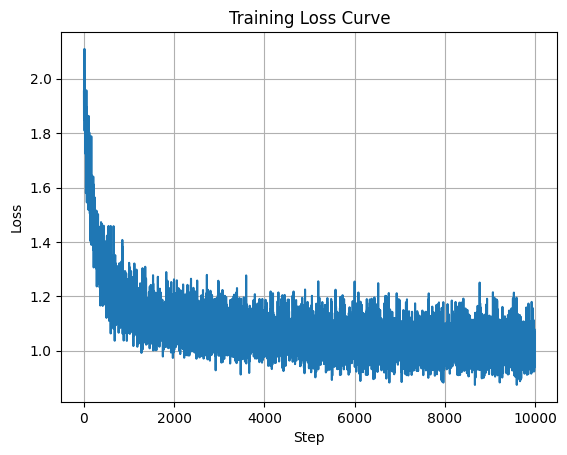

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from Flow_Disentangle_Feature_Importance import FlowMatchingModel

model = FlowMatchingModel(
    X=X_full,
    dim=D,
    device=device,
    hidden_dim=64,        
    time_embed_dim=64,     
    num_blocks=1,
    use_bn=False,
    seed=0
)
model.fit(num_steps=10000, batch_size=256, lr=1e-3, show_plot=True)

## Caculate Feature Importance

In [ ]:
from Flow_Disentangle_Feature_Importance import CPI_Flow_Model_Estimator_cls
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
import numpy as np

estimator3 = CPI_Flow_Model_Estimator_cls(
    random_state=0,
    regressor =  RandomForestClassifier(
                n_estimators=300,
                max_depth=None,
                min_samples_leaf=3,
                random_state=seed,
                n_jobs=n_jobs
                ),
    flow_model=model
)

phi_x_cpi, se_x_cpi = estimator3.importance(X_full, y)

print("Feature\tFDFI φ\tStdError")
for j, (phi_j, se_j) in enumerate(zip(phi_x_cpi, se_x_cpi)):
    print(f"{j:>3d}\t{phi_j: .4f}\t{se_j: .4f}")
print(f"Sum of FDFI: {D* np.mean(phi_x_cpi)}")

phi_x_cpi_test = phi_x_cpi 

se_x_cpi_test = se_x_cpi 

z_score_x_cpi = phi_x_cpi_test / se_x_cpi_test

p_value_x_cpi = 1 - norm.cdf(z_score_x_cpi)
rounded_p_value_x_cpi = np.round(p_value_x_cpi, 3)

print(rounded_p_value_x_cpi)

alpha = 0.05 / 21  

mask = (p_value_x_cpi <= alpha).astype(int)

print(mask)



CPI@Z (resample) → decode → X (cls CE): 100%|██████████| 21/21 [00:02<00:00,  8.20it/s]


Feature	FDFI φ	StdError
  0	 0.0362	 0.0048
  1	 0.0237	 0.0032
  2	 0.0171	 0.0037
  3	 0.0163	 0.0023
  4	 0.0562	 0.0101
  5	 0.0358	 0.0041
  6	 0.1163	 0.0250
  7	 0.0318	 0.0060
  8	 0.0353	 0.0061
  9	 0.0184	 0.0103
 10	 0.1299	 0.0264
 11	 0.0214	 0.0024
 12	 0.0262	 0.0029
 13	 0.0195	 0.0022
 14	 0.0168	 0.0023
 15	 0.0076	 0.0014
 16	 0.0555	 0.0084
 17	 0.0579	 0.0086
 18	 0.0541	 0.0082
 19	 0.0569	 0.0085
 20	 0.0170	 0.0023
Sum of FDFI: 0.8497742736042331
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.037 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]


## Save the Sensitivity matrix

In [ ]:
Z = estimator3._encode_to_Z(X_full)
estimator3.plot_H(Z=Z, export_txt_path="matrix.tsv",
            savepath="matrix.pdf")

# DFI

In [ ]:
from Flow_Disentangle_Feature_Importance import  DFIEstimator_cls
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
import numpy as np

estimator4 = DFIEstimator_cls(
    random_state=0,
    regressor =  RandomForestClassifier(
                n_estimators=300,
                max_depth=None,
                min_samples_leaf=3,
                random_state=seed,
                n_jobs=n_jobs
                )
)

phi_x_dfi, se_x_dfi = estimator4.importance(X_full, y)


print("Feature\tDFI φ\tStdError")
for j, (phi_j, se_j) in enumerate(zip(phi_x_dfi, se_x_dfi)):
    print(f"{j:>3d}\t{phi_j: .4f}\t{se_j: .4f}")
print(f"Sum of DFI: {D* np.mean(phi_x_dfi)}")

phi_x_dfi_test = phi_x_dfi 

se_x_dfi_test = se_x_dfi 

z_score_x_dfi = phi_x_dfi_test / se_x_dfi_test

p_value_x_dfi = 1 - norm.cdf(z_score_x_dfi)
rounded_p_value_x_dfi = np.round(p_value_x_dfi, 3)

print(rounded_p_value_x_dfi)

alpha = 0.05 / 21  

mask = (p_value_x_dfi <= alpha).astype(int)

print(mask)



Feature	DFI φ	StdError
  0	 0.0225	 0.0027
  1	 0.0091	 0.0015
  2	 0.0027	 0.0008
  3	 0.0104	 0.0018
  4	 0.0402	 0.0075
  5	 0.0200	 0.0022
  6	 0.0716	 0.0136
  7	 0.0094	 0.0017
  8	 0.0139	 0.0022
  9	 0.0021	 0.0016
 10	 0.0528	 0.0076
 11	 0.0125	 0.0017
 12	 0.0139	 0.0018
 13	 0.0142	 0.0020
 14	 0.0111	 0.0015
 15	 0.0040	 0.0007
 16	 0.0370	 0.0048
 17	 0.0358	 0.0039
 18	 0.0346	 0.0041
 19	 0.0190	 0.0027
 20	 0.0083	 0.0013
Sum of DFI: 0.4450802284819941
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.096 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]


# Comparison with ad hoc method

We use the top-k features with the highest feature importance obtained from FDFI and DFI for the prediction task, and compare their performance with the top-k features selected by the ad-hoc method. For this dataset, we evaluate top-5 features for the subsequent prediction. This comparison demonstrates the superiority of the FDFI/DFI approach.

## ad hoc method (CPI)

In the ad-hoc approach, **CPI (Conditional Permutation Importance)** is applied *after hierarchical clustering* to mitigate multicollinearity among features.  
The computation proceeds as follows:

1. **Compute Feature Correlations:**  
   Pairwise correlations (typically **Spearman**) are calculated between all features to measure their dependencies.

2. **Perform Hierarchical Clustering:**  
   Using the correlation matrix, features are grouped into clusters so that highly correlated features fall into the same cluster.

3. **Select Cluster Representatives:**  
   From each cluster, one representative feature (*medoid* — the feature most centrally located in the cluster) is chosen to represent that group.  
   The number of clusters is determined by adjusting the **linkage height** in the hierarchical clustering dendrogram.  
   In our setting, the linkage height is tuned so that **2k representative features** are selected in total.  
   This step reduces redundancy and avoids applying CPI to strongly correlated features simultaneously.

4. **Compute CPI for the Representative Features:**  
   CPI is then computed **only for these representative features**, calculating their feature importance to evaluate each representative’s conditional contribution to the prediction task.  
   
5. **Select Top-k Representative Features:**  
   Finally, the **top-k representative features** with the highest importance scores are selected for use in the downstream prediction task.


In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

x_npy_path = "Flow_Disentangle_Feature_Importance/X_Cardiotocography.npy"
y_npy_path = "Flow_Disentangle_Feature_Importance/y_Cardiotocography.npy"

X_full = np.load(x_npy_path)   
y = np.load(y_npy_path)

print("X shape:", X_full.shape)
print("y shape:", y.shape)

n, D = X_full.shape

ctg_names = [
    "LB","AC","FM","UC","DL","DS","DP",
    "ASTV","MSTV","ALTV","MLTV",
    "Width","Min","Max","Nmax","Nzeros","Mode","Mean","Median","Variance","Tendency"
]
feature_names = ctg_names if D == 21 else [f"f{i}" for i in range(D)]
X_df = pd.DataFrame(X_full, columns=feature_names)

corr = spearmanr(X_df).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1.0)
corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)

distance_matrix = 1.0 - np.abs(corr)
linkage = hierarchy.ward(squareform(distance_matrix))

t = 0.7
cluster_ids = hierarchy.fcluster(linkage, t, criterion="distance")
cluster_to_ids = defaultdict(list)
for idx, cid in enumerate(cluster_ids):
    cluster_to_ids[cid].append(idx)

def select_representatives(
    X: np.ndarray,
    y: np.ndarray,
    cluster_to_ids: dict,
    corr_abs: np.ndarray,           # |spearman|
    dist: np.ndarray,               # 1 - |spearman|
    strategy: str = "medoid",
    random_state: int = 0
):
    rng = np.random.RandomState(random_state)
    selected = []

    for cid, ids in cluster_to_ids.items():
        ids = list(ids)
        if len(ids) == 1:
            selected.append(ids[0])
            continue

        if strategy == "first":
            chosen = ids[0]

        elif strategy == "medoid":
            subD = dist[np.ix_(ids, ids)]
            sums = np.sum(subD, axis=1)
            chosen = ids[int(np.argmin(sums))]
        selected.append(chosen)

    return selected

strategy = "medoid"   
selected_feature_idx = select_representatives(
    X_full, y, cluster_to_ids,
    corr_abs=np.abs(corr),
    dist=distance_matrix,
    strategy=strategy,
    random_state=0
)
selected_feature_names = [feature_names[i] for i in selected_feature_idx]
print(f"[{strategy}] selected numbers: {len(selected_feature_idx)}")
print(" selected names:", selected_feature_names)

X_subset = X_full[:, selected_feature_idx]

seed = 0
n_jobs = n_jobs
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

fold_acc = []
for k, (tr_idx, te_idx) in enumerate(skf.split(X_subset, y), start=1):
    X_tr, X_te = X_subset[tr_idx], X_subset[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=3,
        random_state=seed,
        n_jobs=n_jobs
    )
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    fold_acc.append(acc)
    print(f"Fold {k} accuracy (selected features): {acc:.4f}")

print(f"Mean accuracy (2-fold, selected features): {np.mean(fold_acc):.4f} ± {np.std(fold_acc, ddof=1):.4f}")


X shape: (2126, 21)
y shape: (2126,)
[medoid] selected numbers: 10
 selected names: ['Median', 'AC', 'FM', 'UC', 'DL', 'Variance', 'ALTV', 'MLTV', 'Nzeros', 'Tendency']
Fold 1 accuracy (selected features): 0.9690
Fold 2 accuracy (selected features): 0.9765
Mean accuracy (2-fold, selected features): 0.9727 ± 0.0053


In [3]:
from Flow_Disentangle_Feature_Importance import CPIEstimator_cls
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
import numpy as np

estimator5 = CPIEstimator_cls(
        random_state=0,
        regressor =  RandomForestClassifier(
                n_estimators=300,
                max_depth=None,
                min_samples_leaf=3,
                random_state=seed,
                n_jobs=n_jobs
                )

)

phi_0_cpi_ad_hoc, se_0_cpi_ad_hoc = estimator5.importance(X_subset, y)


print("Feature\tCPI__ad_hoc φ\tStdError")
for j, (phi_j, se_j) in enumerate(zip(phi_0_cpi_ad_hoc, se_0_cpi_ad_hoc)):
    print(f"{j:>3d}\t{phi_j: .4f}\t{se_j: .4f}")
print(f"Sum of CPI__ad_hoc: {D* np.mean(phi_0_cpi_ad_hoc)}")


phi_0_cpi_test_ad_hoc = phi_0_cpi_ad_hoc 

se_0_cpi_test_ad_hoc = se_0_cpi_ad_hoc 

z_score_0_cpi_ad_hoc = phi_0_cpi_test_ad_hoc / se_0_cpi_ad_hoc

p_value_0_cpi_ad_hoc = 1 - norm.cdf(z_score_0_cpi_ad_hoc)
rounded_p_value_0_cpi_ad_hoc = np.round(p_value_0_cpi_ad_hoc, 3)

print(rounded_p_value_0_cpi_ad_hoc)

alpha = 0.05 / 10  

mask = (p_value_0_cpi_ad_hoc <= alpha).astype(int)

print(mask)




d:\ancconda\envs\variable\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
CPI conditional permutation: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]

Feature	CPI__ad_hoc φ	StdError
  0	 0.0040	 0.0013
  1	 0.0010	 0.0005
  2	 0.0018	 0.0006
  3	 0.0015	 0.0009
  4	 0.0154	 0.0033
  5	 0.0057	 0.0014
  6	 0.0001	 0.0000
  7	 0.0022	 0.0013
  8	 0.0001	 0.0001
  9	 0.0001	 0.0002
Sum of CPI__ad_hoc: 0.06700309488693866
[0.001 0.02  0.002 0.053 0.    0.    0.122 0.038 0.16  0.326]
[1 0 1 0 1 1 0 0 0 0]


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


top_k = 5
D = X_full.shape[1]

phi_safe = np.nan_to_num(phi_0_cpi_ad_hoc, nan=-np.inf, posinf=-np.inf, neginf=-np.inf)


top_k = min(top_k, D)
selected_feature_idx = np.argsort(phi_safe)[-top_k:][::-1].tolist()

print(f"Top-{top_k} feature indices by CPI_ad_hoc:")
for rank, j in enumerate(selected_feature_idx, start=1):
    print(f"  #{rank}: idx={j:4d}, CPI_ad_hoc={phi_0_cpi_ad_hoc[j]:.6f}, SE={se_0_cpi_ad_hoc[j]:.6f}")

X_subset = X_full[:, selected_feature_idx]

seed = 0
n_jobs = n_jobs
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

fold_acc = []
for k, (tr_idx, te_idx) in enumerate(skf.split(X_subset, y), start=1):
    X_tr, X_te = X_subset[tr_idx], X_subset[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=3,
        random_state=seed,
        n_jobs=n_jobs
    )
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    fold_acc.append(acc)
    print(f"Fold {k} accuracy (selected features): {acc:.4f}")

print(f"Mean accuracy (2-fold, selected features): {np.mean(fold_acc):.4f} ± {np.std(fold_acc, ddof=1):.4f}")

print("Selected indices:", selected_feature_idx)


Top-5 feature indices by CPI_ad_hoc:
  #1: idx=   4, CPI_ad_hoc=0.015436, SE=0.003279
  #2: idx=   5, CPI_ad_hoc=0.005661, SE=0.001446
  #3: idx=   0, CPI_ad_hoc=0.003976, SE=0.001327
  #4: idx=   7, CPI_ad_hoc=0.002234, SE=0.001258
  #5: idx=   2, CPI_ad_hoc=0.001816, SE=0.000617
Fold 1 accuracy (selected features): 0.9614
Fold 2 accuracy (selected features): 0.9652
Mean accuracy (2-fold, selected features): 0.9633 ± 0.0027
Selected indices: [4, 5, 0, 7, 2]


## FDFI

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

top_k = 5
D = X_full.shape[1]

phi_safe = np.nan_to_num(phi_x_cpi, nan=-np.inf, posinf=-np.inf, neginf=-np.inf)

top_k = min(top_k, D)
selected_feature_idx = np.argsort(phi_safe)[-top_k:][::-1].tolist()

print(f"Top-{top_k} feature indices by FDFI:")
for rank, j in enumerate(selected_feature_idx, start=1):
    print(f"  #{rank}: idx={j:4d}, FDFI={phi_x_cpi[j]:.6f}, SE={se_x_cpi[j]:.6f}")

X_subset = X_full[:, selected_feature_idx]

seed = 0
n_jobs = n_jobs
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

fold_acc = []
for k, (tr_idx, te_idx) in enumerate(skf.split(X_subset, y), start=1):
    X_tr, X_te = X_subset[tr_idx], X_subset[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=3,
        random_state=seed,
        n_jobs=n_jobs
    )
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    fold_acc.append(acc)
    print(f"Fold {k} accuracy (selected features): {acc:.4f}")

print(f"Mean accuracy (2-fold, selected features): {np.mean(fold_acc):.4f} ± {np.std(fold_acc, ddof=1):.4f}")

print("Selected indices:", selected_feature_idx)


Top-5 feature indices by FDFI:
  #1: idx=  10, FDFI=0.129866, SE=0.026374
  #2: idx=   6, FDFI=0.116316, SE=0.024964
  #3: idx=  17, FDFI=0.057922, SE=0.008552
  #4: idx=  19, FDFI=0.056941, SE=0.008498
  #5: idx=   4, FDFI=0.056153, SE=0.010097
Fold 1 accuracy (selected features): 0.9802
Fold 2 accuracy (selected features): 0.9840
Mean accuracy (2-fold, selected features): 0.9821 ± 0.0027
Selected indices: [10, 6, 17, 19, 4]


## DFI

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

top_k = 5
D = X_full.shape[1]

phi_safe = np.nan_to_num(phi_x_dfi, nan=-np.inf, posinf=-np.inf, neginf=-np.inf)

top_k = min(top_k, D)
selected_feature_idx = np.argsort(phi_safe)[-top_k:][::-1].tolist()

print(f"Top-{top_k} feature indices by DFI:")
for rank, j in enumerate(selected_feature_idx, start=1):
    print(f"  #{rank}: idx={j:4d}, DFI={phi_x_dfi[j]:.6f}, SE={se_x_dfi[j]:.6f}")

X_subset = X_full[:, selected_feature_idx]

seed = 0
n_jobs = n_jobs

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

fold_acc = []
for k, (tr_idx, te_idx) in enumerate(skf.split(X_subset, y), start=1):
    X_tr, X_te = X_subset[tr_idx], X_subset[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=3,
        random_state=seed,
        n_jobs=n_jobs
    )
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    fold_acc.append(acc)
    print(f"Fold {k} accuracy (selected features): {acc:.4f}")

print(f"Mean accuracy (2-fold, selected features): {np.mean(fold_acc):.4f} ± {np.std(fold_acc, ddof=1):.4f}")

print("Selected indices:", selected_feature_idx)


Top-5 feature indices by DFI:
  #1: idx=   6, DFI=0.071558, SE=0.013623
  #2: idx=  10, DFI=0.052816, SE=0.007611
  #3: idx=   4, DFI=0.040167, SE=0.007468
  #4: idx=  16, DFI=0.036989, SE=0.004771
  #5: idx=  17, DFI=0.035844, SE=0.003948
Fold 1 accuracy (selected features): 0.9831
Fold 2 accuracy (selected features): 0.9793
Mean accuracy (2-fold, selected features): 0.9812 ± 0.0027
Selected indices: [6, 10, 4, 16, 17]
